_Author: Stephen Carr_

In [2]:
using DMRJtensor
include("su2_tools.jl");

In [42]:
# setup system with isotropic J
spinmag = 1.0;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag)
Ns = 20 # number of sites

tar_phase = 2 # 1: AKLT, 2: critical point, 3: Dimerized
θ = 0.0;
if tar_phase == 1
    θ = atan(1.0/3.0)
elseif tar_phase == 2
    θ = -π/4.0
elseif tar_phase == 3
    θ = -π/2.0
end

# J_p array, e.g. H = sum_p[ -J_p (S*S)^p ]
#J_arr = [1.0, 2.0]; # spin nematic?
J_arr = [cos(θ), sin(θ)];
#J_arr = [1.0, 0.0];
H_onesite, H_op_vec = H_SU2(spinmag, J_arr) # make the onsite term


# for manual setting of J terms
J_tensors = []
push!(J_tensors,[1.0, 1.0, 1.0]) # first order terms, S_i
push!(J_tensors,[ [2.0, 0.2, 0.0], [0.0, 2.0, 0.0], [0.0, 0.0, 2.0] ]) # second order terms, S_i S_j
# make the onsite term (uncomment to overrule the J_arr settings)
#H_onesite, H_op_vec = H_SU2_Jtensor(spinmag, J_tensors)

H_mpo = makeMPO(H_onesite,size(Id,1),Ns); # make the MPO!
psi0 = makePsi0(spinmag,Ns);
psi = copy(psi0)
println(psi[1])

MethodError: MethodError: no method matching MPS(::Type{ComplexF64}, ::Vector{Array{ComplexF64, 3}}, ::Int64)
Closest candidates are:
  MPS(::DataType, !Matched::Vector{W}, ::Integer; regtens, oc) where W<:Integer at ~/.julia/packages/DMRJtensor/UXxqr/lib/MPtask.jl:254
  MPS(::DataType, !Matched::Integer, ::Integer; regtens, oc) at ~/.julia/packages/DMRJtensor/UXxqr/lib/MPtask.jl:245
  MPS(::DataType, ::Union{MPS, Vector{W}}; regtens, oc) where W<:Union{Integer, Array} at ~/.julia/packages/DMRJtensor/UXxqr/lib/MPtask.jl:193

In [49]:
nOps = length(H_op_vec)
MPO_op_vec = []
for idx = 1:nOps
    MPO_here = makeMPO(H_op_vec[idx],size(Id,1),Ns);
    push!(MPO_op_vec, MPO_here)
end
println(nOps)
println(size(MPO_op_vec[1].H))
showTens(MPO_op_vec[1].H[1])

12
(20,)
printing regular tensor of type: tens{ComplexF64}
size = [1, 3, 3, 3]
T = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]...


In [6]:
# DMRG sweeps, with refinement 

nsweeps_m10 = 20
nsweeps_m40 = 10
nsweeps_m80 = 5

for i in 1:nsweeps_m10
    @time dmrg(psi, H_mpo, maxm = 10, cutoff = 1E-4)
end
println("coarse run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

for i in 1:nsweeps_m40
    @time dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-8)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

UndefVarError: UndefVarError: psi not defined

In [164]:
# evaluate Correlation matrix

corMat = zeros(ComplexF64,nOps,nOps)

op_expect = zeros(ComplexF64,nOps)

for idx = 1:nOps
    op_expect[idx] = expect(psi,MPO_op_vec[idx])
end

for idx1 = 1:nOps
    for idx2 = 1:nOps
        val_h = 0.5*expect(psi,MPO_op_vec[idx1],MPO_op_vec[idx2])
        val_h += 0.5*expect(psi,MPO_op_vec[idx2],MPO_op_vec[idx1])
        val_h += -(op_expect[idx1]*op_expect[idx2])
        corMat[idx1,idx2] = val_h
    end
end
broadcast(abs,corMat)

12×12 Array{Float64,2}:
 11.5538    4.70617   4.70617  10.1199   …  1.67897   2.92923    5.70265
  4.70617  11.5533    4.70577   5.70263     2.92913   1.67896    5.70223
  4.70617   4.70577  11.5533    5.70262     1.67884   1.67895   10.1195 
 10.1199    5.70263   5.70262  14.0088      1.9813    4.0002     6.39853
  1.67897   1.67884   2.92913   1.9813      0.481701  1.61035    4.00011
  1.67897   2.92913   1.67884   1.9813   …  3.66776   0.48168    1.98118
  1.67897   1.67884   2.92913   1.9813      1.61031   0.481683   4.00011
  5.70265  10.1195    5.70224   6.39853     4.00011   1.98129    6.39815
  2.92923   1.67896   1.67895   4.0002      0.48168   3.66778    1.98128
  1.67897   2.92913   1.67884   1.9813      1.01855   1.61035    1.98118
  2.92923   1.67896   1.67895   4.0002   …  1.61035   1.01851    1.98128
  5.70265   5.70223  10.1195    6.39853     1.98118   1.98128   14.0084 

In [165]:
# check the symmetry of M
maximum(broadcast(abs,corMat - corMat'))

1.1111509033280746e-5

In [168]:
using LinearAlgebra
using Printf

#keep_idx = [1,2,3,4,8,12] # S_i and (S_ii)^2 operators only
keep_idx = 1:12 # all operators
corMat_reduced = corMat[keep_idx,keep_idx]

vals,vecs = LinearAlgebra.eigen(corMat_reduced)
min_val, tar_idx = findmin(broadcast(abs,vals))
#min_val, tar_idx = findmin(broadcast(real,vals))


op_estimate = broadcast(abs,vecs[:,tar_idx])/maximum(broadcast(abs,vecs[:,tar_idx]))

display("J_arr:")
display(J_arr)

@printf("eigenvalues = ")
for val in vals
    @printf("%.5f ",real(val))
end
@printf("\n")

@printf("min_eig = %E \n",min_val)

@printf("operators = ")
for op in op_estimate
    @printf("%.5f ",op)
end
@printf("\n")


"J_arr:"

2-element Array{Float64,1}:
  0.7071067811865476
 -0.7071067811865475

eigenvalues = -6.77834 -6.77832 -0.50225 0.00051 0.22816 0.22817 0.59914 2.57111 2.57111 3.14543 37.64422 37.64592 
min_eig = 5.059888E-04 
operators = 1.00000 0.99999 0.99999 0.99913 0.99913 0.99913 0.99913 0.99914 0.99913 0.99913 0.99913 0.99913 


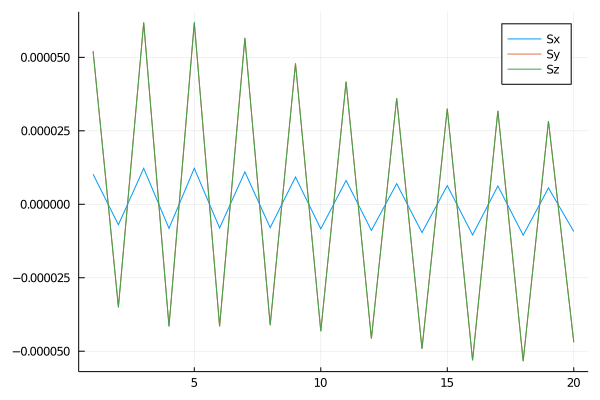

In [169]:
# Evaluate and plot the site-dependent magnetization
S_vals = zeros(ComplexF64,Ns,3)
S_ops = [Sx, Sy, Sz]

S0 = [Id O 
      O Id]
S0_mpo = Array{Array{ComplexF64,2},1}(undef,Ns)

for site = 1:Ns
   S0_mpo[site] = S0
end

for site = 1:Ns
    for op_idx = 1:3
        Sop_here = copy(S0_mpo)
        Sop_here[site] = [Id            O
                          S_ops[op_idx] Id]
        mpo_h = makeMPO(Sop_here,size(Id,1),Ns)
        S_vals[site,op_idx] = expect(psi,mpo_h)
    end
end

using Plots
plot(broadcast(real,S_vals[:,1]),label="Sx")
plot!(broadcast(real,S_vals[:,2]),label="Sy")
plot!(broadcast(real,S_vals[:,3]),label="Sz")

In [172]:
tar_vec = H_op_vec[12]; # 12 corresponds to Sz^2

display("Op mid left:")
display(tar_vec[4:6,1:3])

display("Op bot mid:")
display(tar_vec[7:9,4:6])

display("Id top left:")
display(tar_vec[1:3,1:3])

display("Id bot right:")
display(tar_vec[7:9,7:9])

display("Zero bot left:")
display(tar_vec[7:9,1:3])

display("rest:")
display(tar_vec[1:6,4:9])



"Op mid left:"

3×3 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im

"Op bot mid:"

3×3 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im

"Id top left:"

3×3 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im

"Id bot right:"

3×3 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im

"Zero bot left:"

3×3 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im

"rest:"

6×6 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [181]:
# check the term in the Hamiltonian (top left part is multiplied by respective J)
tar_op = 12;

nH_rows = size(H_onesite)[1]
lrs = nH_rows-2;
s = (tar_op)*3;
display(H_onesite[(1+s):(3+s),1:3])
display(H_onesite[lrs:(lrs+2),(1+s):(3+s)])

3×3 Array{Complex{Float64},2}:
 -0.707107-0.0im  -0.0-0.0im       -0.0-0.0im
      -0.0-0.0im  -0.0-0.0im       -0.0-0.0im
      -0.0-0.0im  -0.0-0.0im  -0.707107-0.0im

3×3 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im